In [4]:
install.packages("support.CEs")

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)
also installing the dependencies ‘zoo’, ‘lmtest’, ‘conf.design’, ‘vcd’, ‘combinat’, ‘numbers’, ‘bitops’, ‘DoE.base’, ‘simex’, ‘RCurl’, ‘XML’



In [8]:
# Traditional Conjoint Analysis (R)

# R preliminaries to get the user-defined function for spine chart: 
# place the spine chart code file <R_utility_program_1.R>
# in your working directory and execute it by
#     source("R_utility_program_1.R")
# Or if you have the R binary file in your working directory, use
#     load(file="mtpa_spine_chart.Rdata")

# spine chart accommodates up to 45 part-worths on one page
# |part-worth| <= 40 can be plotted directly on the spine chart
# |part-worths| > 40 can be accommodated through standardization

print.digits <- 2  # set number of digits on print and spine chart

library(support.CEs)  # package for survey construction 

load(url("https://raw.githubusercontent.com/bscan/notebooks/master/MDS/mtpa_spine_chart.Rdata"))

# generate a balanced set of product profiles for survey
provider.survey <- Lma.design(attribute.names = 
  list(brand = c("AT&T","T-Mobile","US Cellular","Verizon"), 
  startup = c("$100","$200","$300","$400"), 
  monthly = c("$100","$200","$300","$400"),
  service = c("4G NO","4G YES"), 
  retail = c("Retail NO","Retail YES"),
  apple = c("Apple NO","Apple YES"), 
  samsung = c("Samsung NO","Samsung YES"), 
  google = c("Nexus NO","Nexus YES")), nalternatives = 1, nblocks=1, seed=9999)
print(questionnaire(provider.survey))  # print survey design for review

sink("questions_for_survey.txt")  # send survey to external text file
questionnaire(provider.survey)
sink() # send output back to the screen

# user-defined function for plotting descriptive attribute names 
effect.name.map <- function(effect.name) { 
  if(effect.name=="brand") return("Mobile Service Provider")
  if(effect.name=="startup") return("Start-up Cost")
  if(effect.name=="monthly") return("Monthly Cost")
  if(effect.name=="service") return("Offers 4G Service")
  if(effect.name=="retail") return("Has Nearby Retail Store")
  if(effect.name=="apple") return("Sells Apple Products")
  if(effect.name=="samsung") return("Sells Samsung Products")
  if(effect.name=="google") return("Sells Google/Nexus Products")
  } 

# read in conjoint survey profiles with respondent ranks
conjoint.data.frame <- read.csv("https://raw.githubusercontent.com/bscan/notebooks/master/MDS/mobile_services_ranking.csv")

# set up sum contrasts for effects coding as needed for conjoint analysis
options(contrasts=c("contr.sum","contr.poly"))

# main effects model specification
main.effects.model <- {ranking ~ brand + startup + monthly + service + 
  retail + apple + samsung + google}

# fit linear regression model using main effects only (no interaction terms)
main.effects.model.fit <- lm(main.effects.model, data=conjoint.data.frame)
print(summary(main.effects.model.fit)) 

# save key list elements of the fitted model as needed for conjoint measures
conjoint.results <- 
  main.effects.model.fit[c("contrasts","xlevels","coefficients")]

conjoint.results$attributes <- names(conjoint.results$contrasts)

# compute and store part-worths in the conjoint.results list structure
part.worths <- conjoint.results$xlevels  # list of same structure as xlevels
end.index.for.coefficient <- 1  # intitialize skipping the intercept
part.worth.vector <- NULL # used for accumulation of part worths
for(index.for.attribute in seq(along=conjoint.results$contrasts)) {
  nlevels <- length(unlist(conjoint.results$xlevels[index.for.attribute]))
  begin.index.for.coefficient <- end.index.for.coefficient + 1
  end.index.for.coefficient <- begin.index.for.coefficient + nlevels -2
  last.part.worth <- -sum(conjoint.results$coefficients[
    begin.index.for.coefficient:end.index.for.coefficient])
  part.worths[index.for.attribute] <- 
    list(as.numeric(c(conjoint.results$coefficients[
      begin.index.for.coefficient:end.index.for.coefficient],
      last.part.worth)))
  part.worth.vector <- 
    c(part.worth.vector,unlist(part.worths[index.for.attribute]))    
  } 
conjoint.results$part.worths <- part.worths

# compute standardized part-worths
standardize <- function(x) {(x - mean(x)) / sd(x)}
conjoint.results$standardized.part.worths <- 
  lapply(conjoint.results$part.worths,standardize)
 
# compute and store part-worth ranges for each attribute 
part.worth.ranges <- conjoint.results$contrasts
for(index.for.attribute in seq(along=conjoint.results$contrasts)) 
  part.worth.ranges[index.for.attribute] <- 
  dist(range(conjoint.results$part.worths[index.for.attribute]))
conjoint.results$part.worth.ranges <- part.worth.ranges

sum.part.worth.ranges <- sum(as.numeric(conjoint.results$part.worth.ranges))

# compute and store importance values for each attribute 
attribute.importance <- conjoint.results$contrasts
for(index.for.attribute in seq(along=conjoint.results$contrasts)) 
  attribute.importance[index.for.attribute] <- 
  (dist(range(conjoint.results$part.worths[index.for.attribute]))/
  sum.part.worth.ranges) * 100
conjoint.results$attribute.importance <- attribute.importance
 
# data frame for ordering attribute names
attribute.name <- names(conjoint.results$contrasts)
attribute.importance <- as.numeric(attribute.importance)
temp.frame <- data.frame(attribute.name,attribute.importance)
conjoint.results$ordered.attributes <- 
  as.character(temp.frame[sort.list(
  temp.frame$attribute.importance,decreasing = TRUE),"attribute.name"])

# respondent internal consistency added to list structure
conjoint.results$internal.consistency <- summary(main.effects.model.fit)$r.squared 
 
# user-defined function for printing conjoint measures
if (print.digits == 2) 
  pretty.print <- function(x) {sprintf("%1.2f",round(x,digits = 2))} 
if (print.digits == 3) 
  pretty.print <- function(x) {sprintf("%1.3f",round(x,digits = 3))} 
 
# report conjoint measures to console 
# use pretty.print to provide nicely formated output
for(k in seq(along=conjoint.results$ordered.attributes)) {
  cat("\n","\n")
  cat(conjoint.results$ordered.attributes[k],"Levels: ",
  unlist(conjoint.results$xlevels[conjoint.results$ordered.attributes[k]]))
  
  cat("\n"," Part-Worths:  ")
  cat(pretty.print(unlist(conjoint.results$part.worths
    [conjoint.results$ordered.attributes[k]])))
    
  cat("\n"," Standardized Part-Worths:  ")
  cat(pretty.print(unlist(conjoint.results$standardized.part.worths
    [conjoint.results$ordered.attributes[k]])))  
    
  cat("\n"," Attribute Importance:  ")
  cat(pretty.print(unlist(conjoint.results$attribute.importance
    [conjoint.results$ordered.attributes[k]])))
  }

# plotting of spine chart begins here
# all graphical output is routed to external pdf file
#pdf(file = "fig_preference_mobile_services_results.pdf", width=8.5, height=11)
#spine.chart(conjoint.results)
#dev.off()  # close the graphics output device

# Suggestions for the student:
# Enter your own rankings for the product profiles and generate
# conjoint measures of attribute importance and level part-worths.
# Note that the model fit to the data is a linear main-effects model.
# See if you can build a model with interaction effects for service
# provider attributes.



The columns of the array have been used in order of appearance. 
For designs with relatively few columns, 
the properties can sometimes be substantially improved 
using option columns with min3 or even min34.




Block 1 
 
Question 1 
        alt.1       
brand   "AT&T"      
startup "$100"      
monthly "$100"      
service "4G NO"     
retail  "Retail NO" 
apple   "Apple NO"  
samsung "Samsung NO"
google  "Nexus NO"  

Question 2 
        alt.1        
brand   "Verizon"    
startup "$300"       
monthly "$100"       
service "4G NO"      
retail  "Retail YES" 
apple   "Apple YES"  
samsung "Samsung YES"
google  "Nexus NO"   

Question 3 
        alt.1        
brand   "US Cellular"
startup "$400"       
monthly "$200"       
service "4G NO"      
retail  "Retail NO"  
apple   "Apple NO"   
samsung "Samsung YES"
google  "Nexus NO"   

Question 4 
        alt.1       
brand   "Verizon"   
startup "$400"      
monthly "$400"      
service "4G YES"    
retail  "Retail YES"
apple   "Apple NO"  
samsung "Samsung NO"
google  "Nexus NO"  

Question 5 
        alt.1        
brand   "Verizon"    
startup "$200"       
monthly "$300"       
service "4G NO"      
retail  "Retail NO"  
apple   "Apple NO"

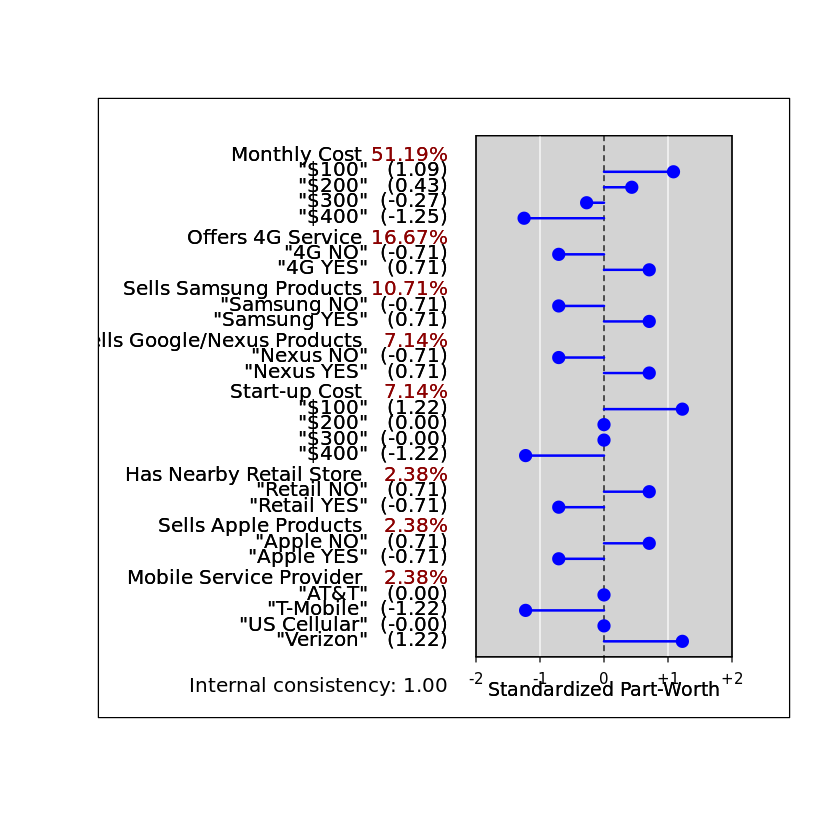

In [7]:
spine.chart(conjoint.results)
